# Trading Bitcoin with Hidden Markov Model

In this notebook I fit a Hidden Markov Model to the Bitcoin historical price data and then use the model as part of a trading strategy that switches an investment between Bitcoin and cash to try and maximize its final portfolio value.

I'm going to simplify things by working with a single averaged Bitcoin price for each day. Initially I will assume that it is always possible to buy and sell as much as I want at a particular day's price with no fees (frictionless market) and later on I will explore the effect of market friction. I will assume that there is zero interest accumulated on the cash but this would be simple to modify. 

Some notation I will use throughout:

$\bullet$ Let $p_{i}$ be the Bitcoin prices on day $i$. 

$\bullet$ Let $r_{i}=\log(p_{i}/p_{i-1})$ be the log rate on day $i$.


# Data import and cleaning 

In [1]:
# import libraries
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import datetime

In [2]:
# Import the bitcoin dataset and encode the date
df =pd.read_csv("../input/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv")
df['date'] = pd.to_datetime(df['Timestamp'],unit='s').dt.date
group = df.groupby('date')
Real_Price = group['Weighted_Price'].mean()

In [3]:
# some days are missing 
# I build a vector of daily prices for each day starting from 2014-12-01
# to 2019-01-07
# probably there is some really wasy way to do this in Pandas but I don't know it!
date=datetime.date(2014,12,1)
enddate=datetime.date(2019,1,7)
j=0
BC_Prices=[]
while date<enddate:
    while Real_Price.index[j]<date:
        j=j+1
        if Real_Price.index[j]==date:
            BC_Prices.append(Real_Price[j])
        else:
            BC_Prices.append(np.nan)
    date=date+datetime.timedelta(days=1)
BC_Prices=np.array(BC_Prices)
ndays=BC_Prices.shape[0]

# fill in missing values with local average
for i in range(ndays):
    if np.isnan(BC_Prices[i]):
        j=i
        while j<ndays and np.isnan(BC_Prices[j]):
            j=j+1
        if j<ndays:
            BC_Prices[i]=0.5*(BC_Prices[i-1]+BC_Prices[j])
        else:
            BC_Prices[i]=BC_Prices[i-1]

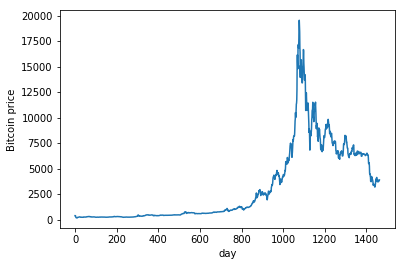

In [4]:
# plot daily prices 
plt.plot(BC_Prices)
plt.xlabel('day')
plt.ylabel('Bitcoin price')
plt.show()

# Baseline Strategy - Previous day trend follower with frictionless environment

In the frictionless environment we can buy and sell at each day's price as much as we want with no fees.

The baseline strategy works as follows:

$\bullet$ We begin with an initial stake of $1

$\bullet$ On day $i$, if $r_{i}\geq 0$ we convert all of our assets into Bitcoin and if $r_{i}<0$ we convert all of our assets into cash. 

In [5]:
Portfolio0=np.zeros((ndays,2))
Portfolio0[0,0]=1
Portfolio0[1,0]=1
a='c'
ntrades=0
for t in range(2,ndays):
    if BC_Prices[t-1]>BC_Prices[t-2]:
        Portfolio0[t-1,1]=Portfolio0[t-1,1]+Portfolio0[t-1,0]/BC_Prices[t-1]
        Portfolio0[t-1,0]=0
        if a=='c':
            ntrades=ntrades+1
            a='b'
    else:
        Portfolio0[t-1,0]=Portfolio0[t-1,0]+Portfolio0[t-1,1]*BC_Prices[t-1]
        Portfolio0[t-1,1]=0 
        if a=='b':
            ntrades=ntrades+1
            a='c'
    Portfolio0[t]=Portfolio0[t-1]

V0=Portfolio0[:,0]+Portfolio0[:,1]*BC_Prices

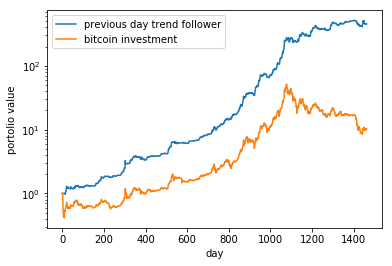

number of trades = 635


In [6]:
plt.semilogy(V0,label='previous day trend follower')
plt.semilogy(BC_Prices/BC_Prices[0],label='bitcoin investment')
plt.legend()
plt.xlabel('day')
plt.ylabel('portolio value')
plt.show()
print('number of trades = '+str(ntrades))

# Previous day trend follower with market friction

The baseline strategy above performs extremely well outperforming the a straight Bitcoin investment by two orders of magnitude. 

However, in practice it is not possible to buy and sell at the same price and without fees. The baseline strategy makes a trade nearly every other day and all these trades will cost a lot in fees or spread and this will cut into the return.

I aggregate all of the possible forms of market friction into a single friction rate $f$. Now when we trade $b$ Bitcoins at price $p$ for cash we only get $\$ (1-f)bp$. Similarly if we buy Bitcoins at price $p$ with $\$c$ cash then we only get $(1-f)c/p$ Bitcoins.

$\bullet$ Below I plot how the return of the previous day trend follower as a function of the friction rate. 

$\bullet$ I have also computed an upper bound for the final return with each level of friction. This is defined by considering a time-traveling trader from the future who can see in advanced all of the future prices. 

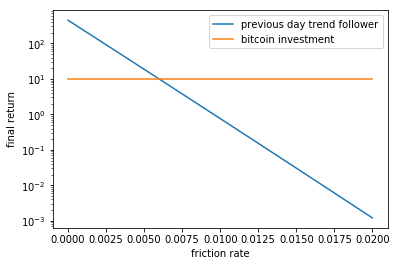

In [7]:
friction=np.linspace(0,0.02,100)
plt.semilogy(friction,V0[-1]*np.power(1-friction,ntrades),label='previous day trend follower')
plt.semilogy([0,0.02],[BC_Prices[-1]/BC_Prices[0],BC_Prices[-1]/BC_Prices[0]],label='bitcoin investment')
plt.legend()
plt.xlabel('friction rate')
plt.ylabel('final return')
plt.show()

In [8]:
UB=np.zeros(100)
TR=np.zeros(100)
for i in range(100):
    f=friction[i]
    c=1
    b=0
    tc=0
    tb=0
    for t in range(1,ndays):
        if (1-f)*b*BC_Prices[t]>c:
            c=(1-f)*b*BC_Prices[t]
            tc=tb+1
        if (1-f)*c/BC_Prices[t]>b:
            b=(1-f)*c/BC_Prices[t]
            tb=tc+1
    UB[i]=c
    TR[i]=tc

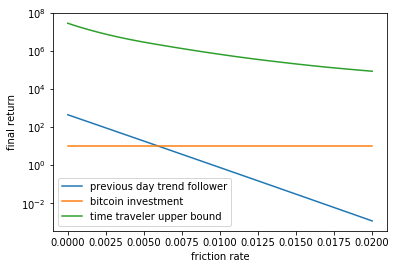

In [9]:
friction=np.linspace(0,0.02,100)
plt.semilogy(friction,V0[-1]*np.power(1-friction,ntrades),label='previous day trend follower')
plt.semilogy([0,0.02],[BC_Prices[-1]/BC_Prices[0],BC_Prices[-1]/BC_Prices[0]],label='bitcoin investment')
plt.semilogy(friction,UB,label='time traveler upper bound')
plt.legend()
plt.xlabel('friction rate')
plt.ylabel('final return')
plt.show()

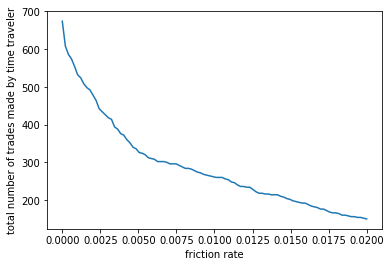

In [10]:
plt.plot(friction,TR)
plt.xlabel('friction rate')
plt.ylabel('total number of trades made by time traveler')
plt.show()

# Hidden Markov Model

I'm going to fit a HMM to the log rate data. Recall that $r_{i}=\log(p_{i}/p_{i-1})$, for $i=2,\dots,n$.

The model I'm using is as follows. 

$\bullet$ The HMM is defined by a transition matrix $P\in\mathbb{R}^{3\times 3}$, a vector $\mu\in\mathbb{R}^{3}$ and two scalars $\beta,\sigma\in\mathbb{R}$.

$\bullet$ The state of the markov chain consists of a pair $x=(h,r)$, where $h\in\{1,2,3\}$ is the hidden state and $r\in\mathbb{R}$ is the log rate. 

$\bullet$ Each day the markov chain jumps $x_{1}\mapsto x_{2}\mapsto \cdots$ The transition probability densities are given by
$$
\rho\big((h,r)\mapsto (h',r')\big)=p_{h',h}~ \phi\left(\frac{r'-\beta r-\mu_{r'}}{\sigma}\right),
$$
where $\phi$ is the standard normal p.d.f. 

Equivalently, the hidden states $h_{1},\dots,h_{n}$ transition according to the matrix $P$ and the rates $r_{1},\dots,r_{n}$ transition according to 
$$
r_{i}=\beta r_{i-1}+\mu_{h(i)}+\sigma z_{i}, 
$$
where $z_{1},\dots,z_{n}$ are i.i.d. standard normals.

# HMM fitting algorithm

To train the HMM I need to split off a training portion of the data. Unlike in most typical ML applications I can't choose this training dataset randomly. Instead I have to choose the beginning of the sequence so that I can then test the model with data that comes from the relative future - so that the test results are indicative of how well the model generalized to unseen future data. I use the 500 days between day 100 and day 600 and call this the training period. 


I fit the HMM by maximizing the negative log likelihood (NLL) of the rates given the model parameters
$$
NLL(\theta)=-\log\left(\rho(r_{1},\dots,r_{m}~|~\theta)\right).
$$
My code below is very rough and inefficient. I don't bother computing the gradient of the NLL analytically although this would be possible and it would massively speed up the optimization. 

Since NLL is a non-convex function I start the optimizer 10 times with different randomly chosen initial conditions. 

In [11]:
from scipy.optimize import minimize

class MHH:

    def fit_HMM(self,Prices,nstarts=10):

        R=np.log(Prices[1:]/Prices[:-1])
        n=R.shape[0]
    
        bnds = ((None,None),(None,None),(None,None),(None,None),(None,0),(None, 0),(None, 0), (0, 1),(0, 1), (0, 1),(None,None))

        def HMM_NLL(x):
            sig=np.exp(x[0])
            MU=x[1:4]
            r0,r1,r2=np.exp(x[4:7])
            p0,p1,p2=x[7:10]
            beta=x[10]
            TP=np.array([[1-r0,r0*p0,r0*(1-p0)],[r1*p1,1-r1,r1*(1-p1)],[r2*p2,r2*(1-p2),1-r2]]).T
            P=np.zeros((n+1,3))
            P[0,:]=np.ones(3)/3
            S=np.zeros(n+1)
            rold=0
            for t in range(n):
                P[t+1]=np.matmul(TP,P[t])
                for j in range(3):
                    P[t+1,j]=P[t+1,j]*np.exp(-0.5*((R[t]-rold*beta-MU[j])/sig)**2)/sig
                rold=R[t]
                S[t+1]=max(P[t+1])
                P[t+1]=P[t+1]/S[t+1]
            nll=-np.sum(np.log(S[1:]))
            return nll

        best=np.inf
        for i in range(nstarts):
            mu0=np.random.rand()*0.001
            mu1=np.random.rand()*0.001
            mu2=-np.random.rand()*0.001
            r0=np.random.rand()
            r1=np.random.rand()
            r2=np.random.rand()
            p0=np.random.rand()
            p1=np.random.rand()
            p2=np.random.rand()
            sig=np.random.rand()*0.1
            beta=np.random.rand()*0.1
            x0=np.array([np.log(sig),mu0,mu1,mu2,np.log(r0),np.log(r1),np.log(r2),p0,p1,p2,beta])

            OPT = minimize(HMM_NLL, x0,bounds=bnds)

            if i==0:
                x=OPT.x    
                OPTbest=OPT

            if OPT.fun<best:
                best=OPT.fun
                x=OPT.x
                OPTbest=OPT

        self.sig=np.exp(x[0])
        self.MU=x[1:4]
        r0,r1,r2=np.exp(x[4:7])
        p0,p1,p2=x[7:10]
        self.TP=np.array([[1-r0,r0*p0,r0*(1-p0)],[r1*p1,1-r1,r1*(1-p1)],[r2*p2,r2*(1-p2),1-r2]]).T
        self.beta=x[10]
        self.x=x
        self.OPT=OPT
        
        # reorder so MU is increasing 
        ix=np.argsort(-self.MU)
        self.MU=self.MU[ix]
        self.TP=self.TP[np.ix_(ix,ix)]
        
    def get_hidden_state_probabilities(self,Prices):
            R=np.log(Prices[1:]/Prices[:-1])
            n=R.shape[0]
            P=np.zeros((n+1,3))
            P[0,:]=np.ones(3)/3
            rold=0
            for t in range(n):
                P[t+1]=np.matmul(self.TP,P[t])
                for j in range(3):
                    P[t+1,j]=P[t+1,j]*np.exp(-0.5*((R[t]-self.beta*rold-self.MU[j])/self.sig)**2)/self.sig
                rold=R[t]
                P[t+1]=P[t+1]/np.sum(P[t+1])
            return P
        
    def get_expected_abnormal_rates(self,Prices):
        P=self.get_hidden_state_probabilities(Prices)
        
        R=np.zeros(Prices.shape[0])
        R[1:]=np.log(Prices[1:]/Prices[:-1])
        
        lam,V=np.linalg.eig(self.TP)
        ix=np.argsort(lam)
        lam=lam[ix]
        V=V[:,ix]
        V[:,2]=V[:,2]/np.sum(V[:,2])
        VMU=np.matmul(V.T,self.MU)
        D=(1/(1-hmm.beta))*(lam[:2]/(1-lam[:2]))*VMU[:2]

        EAR=np.matmul(D,np.linalg.solve(V,P.T)[:2,:])+(1/(1-self.beta))*R
        
        return EAR

# Analysis of HMM on training data


Below I plot the posterior probabilities 
$$
H(i,j)=\mathbb{P}\left(h_{i}=j~|~r_{1},\dots,r_{i}\right),
$$
for the three hidden states $j=1,2,3$ along side the Bitcoin prices for the same period. I've ordered the hidden states so that $\mu$ is decreasing and so that state 1 corresponds to rapid growth, state 2 to slower growth and state 3 to decline. Of course being in state 1/3 doesn't mean that r must be +ve/-ve but it will be more likely. It is clear that the model is able to pick out short periods when the Bitcoin growth rate is either very high positive or is negative. 

I define a quantity which I call the expected abnormal rate which is a function of the state of the Markov chain defined by
$$
A(h,r)=\lim_{n\rightarrow \infty}\mathbb{E}\left(\sum_{t=1}^{n} (r_{t}-\gamma)~\Big|~r_{0}=r,h_{0}=h\right),
$$
where $\gamma$ is the average rate which is defined by
$$
\gamma=\lim_{n\rightarrow \infty} \frac{1}{n}\mathbb{E}\left(\sum_{t=1}^{n} r_{t}\right).
$$
Note that the definition of $\gamma$ is independent of the initial conditions but that $A(h_{i},r_{i})$ is not.

I also deine the posterior expected abnormal rate 
$$
B(i)=\mathbb{E}\left(A(h,r)~|~r_{1},\dots,r_{i}\right),
$$
which I plot alongside the Bitcoin price for the training period. The posterior expected abnormal rate provides a useful measure for the expected short term future behavior of the Bitcoin price given its history. I will use this measure to decide when to buy and sell the Bitcoins.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log


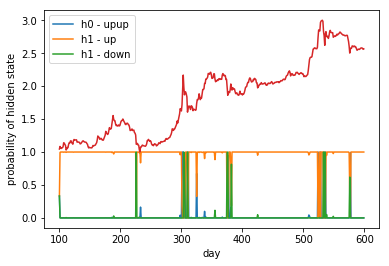

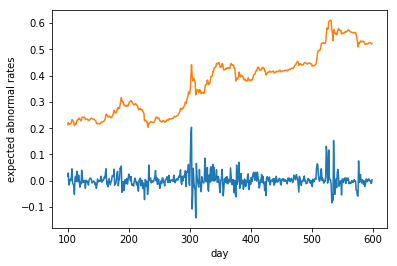

beta = 0.18410712066037063


MU =
[ 0.0787117   0.00143514 -0.08588966]


P =
[[0.24128017 0.00912846 0.45111676]
 [0.64218189 0.97773754 0.34719952]
 [0.11653793 0.013134   0.20168372]]


In [12]:
train_start=100
train_end=600
Prices=BC_Prices[train_start:train_end]

hmm=MHH()
hmm.fit_HMM(Prices)

LP=np.log(Prices)
pmin=np.min(LP)
pmax=np.max(LP)
LP=(LP-pmin)/(pmax-pmin)

P=hmm.get_hidden_state_probabilities(Prices)
plt.plot(range(train_start,train_end),P[:,0],label='h0 - upup')
plt.plot(range(train_start,train_end),P[:,1],label='h1 - up')
plt.plot(range(train_start,train_end),P[:,2],label='h1 - down')
plt.plot(range(train_start,train_end),LP*2+1)
plt.legend()
plt.xlabel('day')
plt.ylabel('probability of hidden state')
plt.show()

EAR=hmm.get_expected_abnormal_rates(Prices)
plt.plot(range(train_start,train_end),EAR)
plt.plot(range(train_start,train_end),(LP*2+1)*np.max(EAR))
plt.xlabel('day')
plt.ylabel('expected abnormal rates')
plt.show()

print('beta = '+str(hmm.beta))
print('\n')
print('MU =')
print(hmm.MU)
print('\n')
print('P =')
print(hmm.TP)

# Trading strategy

My strategy is to monitor the posterior expected abnormal rate and buy Bitcoin when it climbs above a certain threshold and sell it when it drops below another threshold. Let $\tau_{b}$ be the buying threshold and let $\tau_{s}$ be the selling threshold then

$\bullet$ I start with $\$ 1$ in cash.

$\bullet$ On day $i$ if $B(i)\geq \tau_{b}$ then I convert all of my assets into Bitcoin. If $B(i)< \tau_{c}$ then I convert all of my assets into cash and otherwise I do nothing. 

I choose these threshold values to optimize the return on the training period. The code below finds the optimal buying and selling thresholds for a range of friction rate values. Note that for larger friction rates (where trading is more expensive) there is a bigger gap between the thresholds meaning that the trading strategy wants to see a more extreme value for the expected abnormal rate before it makes a trade. 

In [13]:
# back train buy/sell policies
res=200
X=np.linspace(-0.1,0.1,res)
def back_train_pol(mdl,Prices):
    P=mdl.get_hidden_state_probabilities(Prices)
    EAR=mdl.get_expected_abnormal_rates(Prices)
    n=P.shape[0]
    best=-np.inf
    R=np.zeros((res,res))
    T=np.zeros((res,res))
    for j in range(res):
        for i in range(j,res):
            buy=X[i] # buy when EAR>buy
            sell=X[j] # sell when EAR<sell
            a='c'
            pc=1
            pb=0
            ntrades=0
            for t in range(n):
                if a=='c' and EAR[t]>buy:
                    pb=pc/Prices[t]
                    pc=0
                    a='b'
                    ntrades=ntrades+1
                if a=='b' and EAR[t]<sell:
                    pc=pb*Prices[t]
                    pb=0
                    a='c'
                    ntrades=ntrades+1
            score=pc+pb*Prices[t]
            R[i,j]=score
            T[i,j]=ntrades
    return R,T

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


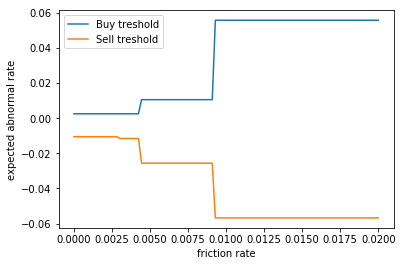

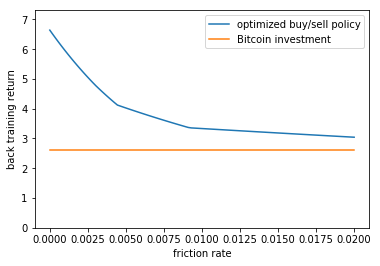

In [14]:
R,T=back_train_pol(hmm,Prices)
Back_train_Return=np.zeros(100)
Buy_Price=np.zeros(100)
Sell_Price=np.zeros(100)
for i in range(100):
    f=friction[i]
    FR=np.log(R)+T*np.log(1-f)
    ix=np.argmax(FR)
    i1=np.mod(ix,res)
    i0=int((ix-i1)/res)
    Back_train_Return[i]=np.exp(FR[i0,i1])
    Buy_Price[i]=X[i0]
    Sell_Price[i]=X[i1]

plt.plot(friction,Buy_Price,label='Buy treshold')
plt.plot(friction,Sell_Price,label='Sell treshold')
plt.xlabel('friction rate')
plt.ylabel('expected abnormal rate')
plt.legend()
plt.show()

plt.plot(friction,Back_train_Return,label='optimized buy/sell policy')
plt.plot([0,np.max(friction)],[Prices[-1]/Prices[0],Prices[-1]/Prices[0]],label='Bitcoin investment')
plt.ylim([0, 1.1*np.max(Back_train_Return)])
plt.xlabel('friction rate')
plt.ylabel('back training return')
plt.legend()
plt.show()

# Testing strategy on test period

Now I have found optimal buy/sell thresholds for each friction rate I can test my strategies on the reminder of the data. 

Below I plot the return from a $\$1$ cash start on day 600 for the different strategies and different friction rates.

We can see that my HMM strategy is always able to beat the basic Bitcoin investment and the previous day trend follower, but that the gap between the basic Bitcoin investment and HMM goes to zero as the friction rate grows. 

You can also see that although I look at one hundred different values for the friction rate, my method only ever picks out three different policies - i.e. three different sets of thresholds. This is what gives the log return vs friction rate plot its picewize linear shape. These policies are the best choice for the training period, but it is clear that they are not always optimal for the test period. 

I have also plotted the value of the HMM portfolio as a function of time for three different values of the friction rate. For the 0.5% the HMM strategy is able to grow even faster than the Bitcoin price during its climb and then avoid any long term losses whilst it declines. For the higher friction rates the HMM strategy follows Bitcoin during the climb  and manages to avoid some of the fall.

In [15]:
# back test
def back_test_pol(mdl,friction,Buy_Price,Sell_Price,Prices):
    P=mdl.get_hidden_state_probabilities(Prices)
    EAR=mdl.get_expected_abnormal_rates(Prices)
    n=P.shape[0]
    Portfolios=np.zeros((100,n,2))
    Value=np.zeros((100,n))
    for i in range(100):
        buy=Buy_Price[i]
        sell=Sell_Price[i]
        rate=1-friction[i]
        Portfolios[i,0,0]=1
        a='c'
        for t in range(n-1):
            if a=='c' and EAR[t]>buy:
                Portfolios[i,t,1]=rate*Portfolios[i,t,0]/Prices[t]
                Portfolios[i,t,0]=0
                a='b'
            if a=='b' and EAR[t]<sell:
                Portfolios[i,t,0]=rate*Portfolios[i,t,1]*Prices[t]
                Portfolios[i,t,1]=0
                a='c'
            Portfolios[i,t+1]=Portfolios[i,t]
        Value[i]=Portfolios[i,:,0]+Portfolios[i,:,1]*Prices
    return Portfolios,Value

In [16]:
Portfolios1,V1=back_test_pol(hmm,friction,Buy_Price,Sell_Price,BC_Prices)

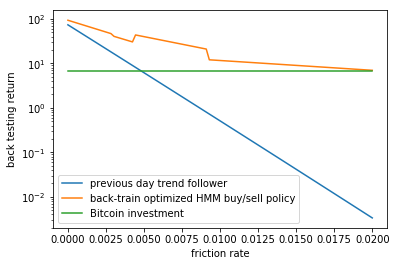

In [17]:
ntrades_in_test_period0=np.sum(Portfolio0[train_end:-1]*Portfolio0[train_end+1:]>0)
plt.semilogy(friction,V0[-1]/V0[train_end]*np.power(1-friction,ntrades_in_test_period0),label='previous day trend follower')

plt.semilogy(friction,V1[:,-1]/V1[:,train_end],label='back-train optimized HMM buy/sell policy')
plt.semilogy([0,np.max(friction)],[BC_Prices[-1]/BC_Prices[train_end],BC_Prices[-1]/BC_Prices[train_end]],label='Bitcoin investment')
plt.legend()
plt.xlabel('friction rate')
plt.ylabel('back testing return')
plt.show()

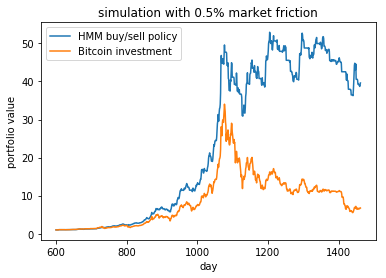

In [18]:
i=25
plt.plot(range(train_end,ndays),V1[i,train_end:]/V1[i,train_end],label='HMM buy/sell policy')
plt.plot(range(train_end,ndays),BC_Prices[train_end:]/BC_Prices[train_end],label='Bitcoin investment')
plt.xlabel('day')
plt.ylabel('portfolio value')
plt.title('simulation with 0.5% market friction')
plt.legend()
plt.show()

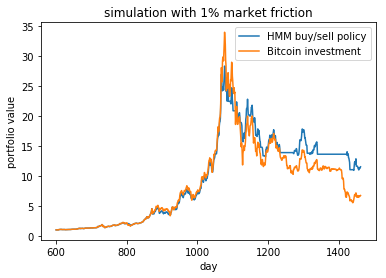

In [19]:
i=50
plt.plot(range(train_end,ndays),V1[i,train_end:]/V1[i,train_end],label='HMM buy/sell policy')
plt.plot(range(train_end,ndays),BC_Prices[train_end:]/BC_Prices[train_end],label='Bitcoin investment')
plt.xlabel('day')
plt.ylabel('portfolio value')
plt.title('simulation with 1% market friction')
plt.legend()
plt.show()

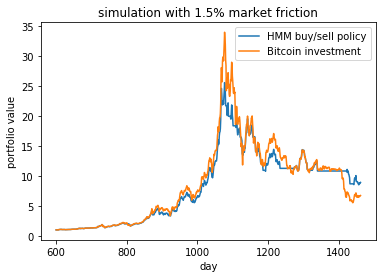

In [20]:
i=75
plt.plot(range(train_end,ndays),V1[i,train_end:]/V1[i,train_end],label='HMM buy/sell policy')
plt.plot(range(train_end,ndays),BC_Prices[train_end:]/BC_Prices[train_end],label='Bitcoin investment')
plt.xlabel('day')
plt.ylabel('portfolio value')
plt.title('simulation with 1.5% market friction')
plt.legend()
plt.show()

# Training with simulated data

I had originally planned to choose my trading policy using Reinforcement Learning to optimize the performance on simulated data sampled from the HMM. However with my current model I do not think that will work well.

The problem is that the HMM samples do not look much like the price data that the HMM was trained on. In particular it switches too quickly between the hidden states so that its overall behaviour is more consistent than the real life Bitcion data. 

Below I try choosing the buy/sell thresholds to optimize performance on sampled data and then test this on the test period as above. As you can see this results in a policy that tends not to do anything for moderately large friction rates and as a result it does not work nearly as well as choosing the thresholds to optimize performance on the real data. 

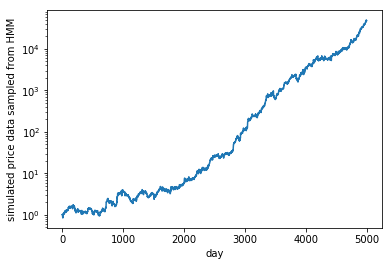

In [21]:
s=0
r=0
n=5000
Rsampled=np.zeros(n)
for t in range(n):
    s=np.random.choice(range(3),p=hmm.TP[:,s])
    r=hmm.beta*r+hmm.MU[s]+np.random.randn()*hmm.sig
    Rsampled[t]=r
Psampled=np.exp(np.cumsum(Rsampled))
plt.semilogy(Psampled)
plt.ylabel('simulated price data sampled from HMM')
plt.xlabel('day')
plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


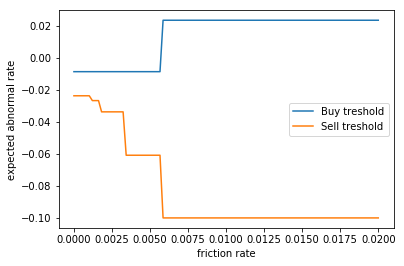

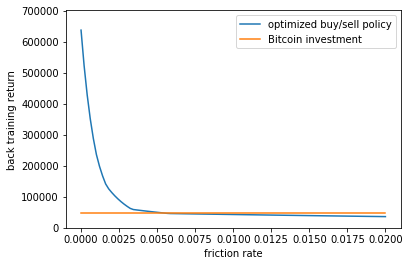

In [22]:
R,T=back_train_pol(hmm,Psampled)
Back_train_Return=np.zeros(100)
Buy_Price=np.zeros(100)
Sell_Price=np.zeros(100)
for i in range(100):
    f=friction[i]
    FR=np.log(R)+T*np.log(1-f)
    ix=np.argmax(FR)
    i1=np.mod(ix,res)
    i0=int((ix-i1)/res)
    Back_train_Return[i]=np.exp(FR[i0,i1])
    Buy_Price[i]=X[i0]
    Sell_Price[i]=X[i1]

plt.plot(friction,Buy_Price,label='Buy treshold')
plt.plot(friction,Sell_Price,label='Sell treshold')
plt.xlabel('friction rate')
plt.ylabel('expected abnormal rate')
plt.legend()
plt.show()
    
plt.plot(friction,Back_train_Return,label='optimized buy/sell policy')
plt.plot([0,np.max(friction)],[Psampled[-1]/Psampled[0],Psampled[-1]/Psampled[0]],label='Bitcoin investment')
plt.ylim([0, 1.1*np.max(Back_train_Return)])
plt.xlabel('friction rate')
plt.ylabel('back training return')
plt.legend()
plt.show()

In [23]:
# back test
def back_test_pol(mdl,friction,Buy_Price,Sell_Price,Prices):
    P=mdl.get_hidden_state_probabilities(Prices)
    EAR=mdl.get_expected_abnormal_rates(Prices)
    n=P.shape[0]
    Portfolios=np.zeros((100,n,2))
    Value=np.zeros((100,n))
    for i in range(100):
        buy=Buy_Price[i]
        sell=Sell_Price[i]
        rate=1-friction[i]
        Portfolios[i,0,0]=1
        a='c'
        for t in range(n-1):
            if a=='c' and EAR[t]>buy:
                Portfolios[i,t,1]=rate*Portfolios[i,t,0]/Prices[t]
                Portfolios[i,t,0]=0
                a='b'
            if a=='b' and EAR[t]<sell:
                Portfolios[i,t,0]=rate*Portfolios[i,t,1]*Prices[t]
                Portfolios[i,t,1]=0
                a='c'
            Portfolios[i,t+1]=Portfolios[i,t]
        Value[i]=Portfolios[i,:,0]+Portfolios[i,:,1]*Prices
    return Portfolios,Value

In [24]:
Portfolios1,V1=back_test_pol(hmm,friction,Buy_Price,Sell_Price,BC_Prices)

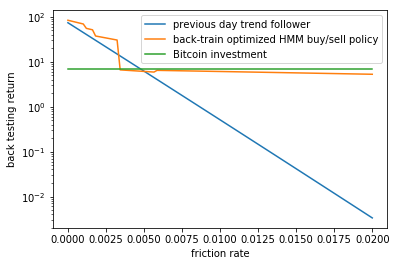

In [25]:
ntrades_in_test_period0=np.sum(Portfolio0[train_end:-1]*Portfolio0[train_end+1:]>0)
plt.semilogy(friction,V0[-1]/V0[train_end]*np.power(1-friction,ntrades_in_test_period0),label='previous day trend follower')

plt.semilogy(friction,V1[:,-1]/V1[:,train_end],label='back-train optimized HMM buy/sell policy')
plt.semilogy([0,np.max(friction)],[BC_Prices[-1]/BC_Prices[train_end],BC_Prices[-1]/BC_Prices[train_end]],label='Bitcoin investment')
plt.legend()
plt.xlabel('friction rate')
plt.ylabel('back testing return')
plt.show()

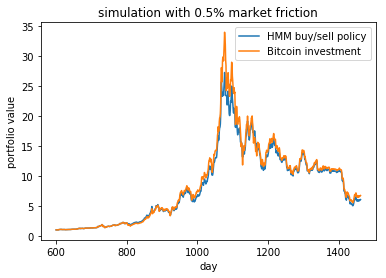

In [26]:
i=25
plt.plot(range(train_end,ndays),V1[i,train_end:]/V1[i,train_end],label='HMM buy/sell policy')
plt.plot(range(train_end,ndays),BC_Prices[train_end:]/BC_Prices[train_end],label='Bitcoin investment')
plt.xlabel('day')
plt.ylabel('portfolio value')
plt.title('simulation with 0.5% market friction')
plt.legend()
plt.show()

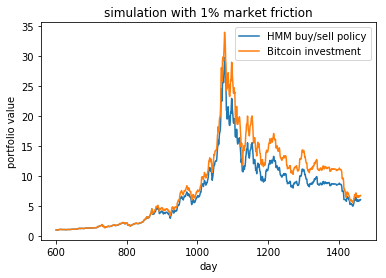

In [27]:
i=50
plt.plot(range(train_end,ndays),V1[i,train_end:]/V1[i,train_end],label='HMM buy/sell policy')
plt.plot(range(train_end,ndays),BC_Prices[train_end:]/BC_Prices[train_end],label='Bitcoin investment')
plt.xlabel('day')
plt.ylabel('portfolio value')
plt.title('simulation with 1% market friction')
plt.legend()
plt.show()

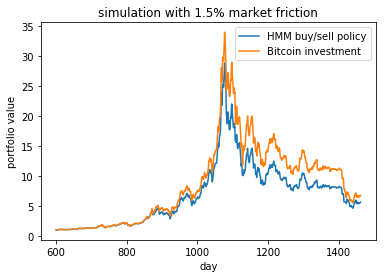

In [28]:
i=75
plt.plot(range(train_end,ndays),V1[i,train_end:]/V1[i,train_end],label='HMM buy/sell policy')
plt.plot(range(train_end,ndays),BC_Prices[train_end:]/BC_Prices[train_end],label='Bitcoin investment')
plt.xlabel('day')
plt.ylabel('portfolio value')
plt.title('simulation with 1.5% market friction')
plt.legend()
plt.show()

# Conclusion 

My trading strategy works reasonably well for small values of market friction. The HMM is able to detect upwards and downwards trends in the data and this can be used to make trading decisions. In its current form my method is using the HMM as a feature extraction device rather than as a predictive model. I would really like to develop the modeling a bit further so that I get a HMM that can simulate data that looks more like the real time-series and allows for some more interesting predictive models and/or reinforcement learning. 

One possibility is putting constraints or regularization on the NLL optimization to try and get models that switch more slowly between hidden states. I'm not sure of a principled way to approach this but will give it some thought. 

I also experimented with some different HMM structures. With two hidden states the model wanted growth and fast growth rather than growth and decline. Without the $\beta r_{i-1}$ type term the state of the HMM is too simple to be able to make fine tuned decisions from.  

This is a work in progress and I hope to update it with some new ideas and neater/more efficient code in the future. If you have any comments please let me know. 

Cheers

James